<a href="https://colab.research.google.com/github/ums-l200220234/ums-l200220234.github.io/blob/main/data_cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MengImport dan Menginstall Library yang diperlukan untuk Preprocessing dan Clustering

In [ ]:
!pip install Sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 6.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.preprocessing import StandardScaler
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import numpy as np
import string
import nltk
import re
import tarfile
import torch

In [ ]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()
lemmatizer = WordNetLemmatizer()

# Preprocessing Dataset yang akan di Clustering

## Pemrosesan untuk Metaflow

In [ ]:
file_path = "/content/sample_data/Chat_Raw_Dataset.txt"

data = []
with open(file_path, 'r', encoding='utf-8') as file:
    for line in file:
        match = re.match(r"(\d+/\d+/\d+), (\d+:\d+\s[AP]M) - (.*?): (.*)", line.strip())
        if match:
            tanggal, waktu, nama, pesan = match.groups()
            data.append({"Tanggal": tanggal, "Waktu": waktu, "Konten": nama + ': ' + pesan,})

In [ ]:
df = pd.DataFrame(data)
csv_file = 'chat_cleaned.csv'
df.to_csv(csv_file, index=False)

In [ ]:
df.head()

,Tanggal,Waktu,Konten
0,8/16/22,3:13 PM,Linda: Assalamu'alaikum temen temen. Pak Marma...
1,8/16/22,3:14 PM,"Laily: Wa'alaikumussalam Tante, ga pake cap 3 ..."
2,8/16/22,3:30 PM,Linda: Ya ambil ijazah kan mesti sambil cap 3 ...
3,8/16/22,3:31 PM,"Laily: Oke Tante Linda , makasih"
4,8/16/22,3:31 PM,"Ghulami'ah: Titip tangan, buat nanti cap tiga ..."


In [ ]:
print(df.shape)

(7780, 3)


In [ ]:
with tarfile.open('chat_cleaned.tar', mode='w') as tar:
    tar.add('chat_cleaned.csv', arcname='chat_cleaned.csv')

## Pemrosesan untuk Clustering

In [ ]:
def load_dataset(file_path):
    df = pd.read_csv(file_path)
    print(f"Dataset loaded with {len(df)} records.")
    return df

In [ ]:
df = load_dataset("/content/chat_cleaned.csv")

Dataset loaded with 7780 records.


In [ ]:
def clean_data(df):
    df = df.dropna(subset=['Konten'])
    df = df[df['Konten'].str.strip() != ""]
    df = df.head(1000)
    print(f"Dataset cleaned. Remaining records: {len(df)}.")
    return df

In [ ]:
def preprocess_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    words = word_tokenize(text)
    stemmed_words = [stemmer.stem(word) for word in words]
    lemmatized_words = [lemmatizer.lemmatize(word, pos=wordnet.VERB) for word in stemmed_words]
    return ' '.join(lemmatized_words)

In [ ]:
def preprocess_batch_gpu(texts):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    results = []
    for text in texts:
        processed_text = preprocess_text(text)
        results.append(processed_text)
    return results

In [ ]:
def preprocess_dataset(df):
    df = clean_data(df)
    df['Processed_Konten'] = df['Konten'].apply(preprocess_text)
    print("Preprocessing completed.")
    return df


In [ ]:
### Hanya Gunakan Jika ingin pre-proses data dengan gpu
def preprocess_dataset(df):
    df = clean_data(df)
    df['Processed_Konten'] = preprocess_batch_gpu(df['Konten'].tolist())
    print("Preprocessing completed.")
    return df


In [ ]:
df = clean_data(df)
df = preprocess_dataset(df)

Dataset cleaned. Remaining records: 1000.
Dataset cleaned. Remaining records: 1000.
Preprocessing completed.


In [ ]:
def scale_data(text_data):
    vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(text_data)
    print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")

    normalizer = Normalizer()
    scaled_matrix = normalizer.fit_transform(tfidf_matrix)
    print(f"Normalized matrix shape: {scaled_matrix.shape}")

    return scaled_matrix, vectorizer.get_feature_names_out()

In [ ]:
scaled_matrix, feature_names = scale_data(df['Konten'])

TF-IDF matrix shape: (1000, 1000)
Normalized matrix shape: (1000, 1000)


In [ ]:
print(df)

     Tanggal     Waktu                                             Konten  \
0    8/16/22   3:13 PM  Linda: Assalamu'alaikum temen temen. Pak Marma...   
1    8/16/22   3:14 PM  Laily: Wa'alaikumussalam Tante, ga pake cap 3 ...   
2    8/16/22   3:30 PM  Linda: Ya ambil ijazah kan mesti sambil cap 3 ...   
3    8/16/22   3:31 PM                   Laily: Oke Tante Linda , makasih   
4    8/16/22   3:31 PM  Ghulami'ah: Titip tangan, buat nanti cap tiga ...   
..       ...       ...                                                ...   
995  10/9/22   9:55 PM  Bos Riio: belajar bersama, lintas jurusan, lin...   
996  10/9/22   9:58 PM                            +62 896-6897-3286: bner   
997  10/9/22  10:00 PM                                    Venka: Nahh se7   
998  10/9/22  10:06 PM                    Linda: Ayo blajarr yg tutor rio   
999  10/9/22  10:06 PM                                   Linda: Bu deBBet   

                                      Processed_Konten  
0    linda assalam

#Clustering teks Dataset dengan K-Means

In [ ]:
def elbow_method(data, max_clusters=10):
    distortions = []
    k_values = range(1, max_clusters + 1)

    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(data)
        distortions.append(kmeans.inertia_)

    plt.figure(figsize=(8, 5))
    plt.plot(k_values, distortions, marker='o', linestyle='--')
    plt.title('Elbow Method')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.grid()
    plt.show()

    return distortions

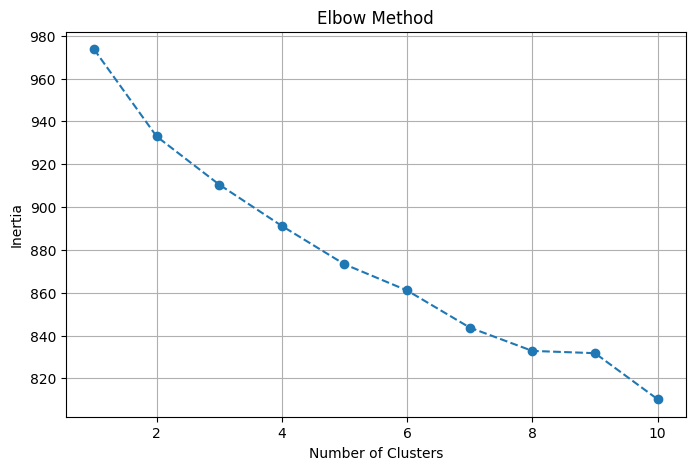

[973.6987778800277,
 932.9869708970635,
 910.485105817183,
 891.1693090310072,
 873.290675540925,
 861.0376437881501,
 843.7200782647772,
 832.8069984543148,
 831.7487659623195,
 810.2456713968521]

In [ ]:
elbow_method(scaled_matrix)

In [ ]:
def perform_kmeans(scaled_matrix, num_clusters=10):
    kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
    kmeans.fit(scaled_matrix)
    print(f"K-Means clustering completed with {num_clusters} clusters.")
    return kmeans.labels_

In [ ]:
labeling = perform_kmeans(scaled_matrix, num_clusters = 7)

K-Means clustering completed with 7 clusters.


In [ ]:

output_file = "labeled_data.csv"

def save_results(df, labels, output_file):
    df['Cluster'] = labels
    df.to_csv(output_file, index=False)
    print(f"Results saved to {output_file}.")

In [ ]:
save_results(df, labeling, output_file)

Results saved to labeled_data.csv.


In [ ]:
def count_per_cluster(labels):
    unique, counts = np.unique(labels, return_counts=True)
    cluster_counts = dict(zip(unique, counts))
    print(f"Jumlah data per kluster: {cluster_counts}")
    return cluster_counts

cluster_counts = count_per_cluster(labeling)

Jumlah data per kluster: {0: 96, 1: 65, 2: 117, 3: 62, 4: 174, 5: 412, 6: 74}
